In [34]:
pip install mealpy mealpy==3.0.1

Note: you may need to restart the kernel to use updated packages.Defaulting to user installation because normal site-packages is not writeable




[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
import json
import numpy as np
import time
import matplotlib.pyplot as plt

# Load the task-VM dataset
with open("data_10000_5.json") as f:
    
    data = json.load(f)

print(f"Loaded {len(data['task'])} tasks and {data['vmcount'][0]} VMs.")


Loaded 10000 tasks and 5 VMs.


In [26]:
def vm_makespan_fitness(solution):
    list1 = [0] * data['vmcount'][0]
    for i in range(len(solution)):
        index = int(abs(round(solution[i])))
        if index != 0:
            list1[index - 1] += data['task'][i] / data['VM'][index - 1]
        else:
            list1[index] += data['task'][i] / data['VM'][index]
    return max(list1)


In [27]:
def Fun1(solution):
    list1 = [0] * data['vmcount'][0]
    val = 0.0
    for i in range(solution.size):
        solution[i] = round(solution[i])
        if round(solution[i]) != 0.0:
            list1[int(abs(round(solution[i], 0))) - 1] = list1[int(abs(round(solution[i], 0))) - 1] + \
                data['task'][0] / data['VM'][int(abs(round(solution[i], 0))) - 1]
        else:
            list1[int(abs(round(solution[i], 0)))] = list1[int(abs(round(solution[i], 0)))] + \
                data['task'][0] / data['VM'][int(abs(round(solution[i], 0)))]
    print(max(list1))
    l = max(list1)
    utili = [x / l for x in list1]
    import numpy as np
    print(np.mean(utili) * 100)


In [28]:
def Fun(solution):
    list1 = [0] * data['vmcount'][0]
    val = 0.0
    for i in range(solution.size):
        solution[i] = round(solution[i])
        if round(solution[i]) != 0.0:
            list1[int(round(solution[i])) - 1] = list1[int(round(solution[i])) - 1] + \
                data['task'][0] / data['VM'][int(round(solution[i])) - 1]
        else:
            list1[int(round(solution[i]))] = list1[int(round(solution[i]))] + \
                data['task'][0] / data['VM'][int(round(solution[i]))]
    return max(list1)


Iteration 1/20, Best Fitness = 58336.000000
Iteration 2/20, Best Fitness = 58336.000000
Iteration 3/20, Best Fitness = 58336.000000
Iteration 4/20, Best Fitness = 58336.000000
Iteration 5/20, Best Fitness = 58336.000000
Iteration 6/20, Best Fitness = 58336.000000
Iteration 7/20, Best Fitness = 58336.000000
Iteration 8/20, Best Fitness = 58336.000000
Iteration 9/20, Best Fitness = 58336.000000
Iteration 10/20, Best Fitness = 58336.000000
Iteration 11/20, Best Fitness = 58336.000000
Iteration 12/20, Best Fitness = 58336.000000
Iteration 13/20, Best Fitness = 58336.000000
Iteration 14/20, Best Fitness = 58336.000000
Iteration 15/20, Best Fitness = 58336.000000
Iteration 16/20, Best Fitness = 58336.000000
Iteration 17/20, Best Fitness = 58336.000000
Iteration 18/20, Best Fitness = 58336.000000
Iteration 19/20, Best Fitness = 58336.000000
Iteration 20/20, Best Fitness = 58336.000000

Best Fitness Score: 58336.000000
Total Execution Time: 141.0792 seconds


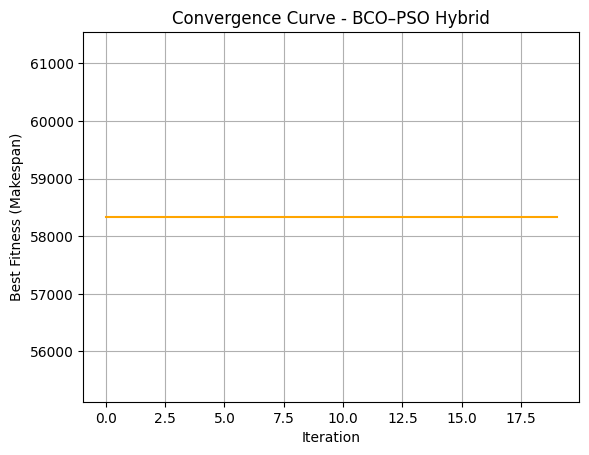

In [29]:
class BCO_PSO_Hybrid:
    def __init__(self, fitness_function, bounds, num_bacteria=30, num_iterations=100,
                 C_min=0.01, C_max=0.1, n=2,
                 reproduction_interval=20, pso_update_interval=30, pso_update_prob=0.1):
        self.fitness_function = fitness_function
        self.bounds = bounds
        self.num_bacteria = num_bacteria
        self.num_iterations = num_iterations
        self.C_min = C_min
        self.C_max = C_max
        self.n = n
        self.reproduction_interval = reproduction_interval
        self.pso_update_interval = pso_update_interval
        self.pso_update_prob = pso_update_prob

    def _adaptive_step(self, iteration):
        return self.C_min + ((self.num_iterations - iteration) / self.num_iterations) ** self.n * (self.C_max - self.C_min)

    def _tumble_swim(self, position, C, G_best, P_best, turbulent_strength=0.001):
        f = np.random.rand()
        turbulence = np.random.uniform(-turbulent_strength, turbulent_strength, size=position.shape)
        direction = f * (G_best - position) + (1 - f) * (P_best - position) + turbulence
        return position + C * direction

    def optimize(self, num_dimensions):
        lower, upper = self.bounds
        population = np.random.uniform(lower, upper, (self.num_bacteria, num_dimensions))
        velocity = np.zeros_like(population)

        fitness = np.array([self.fitness_function(ind) for ind in population])
        P_best = population.copy()
        P_best_fitness = fitness.copy()
        G_best = population[np.argmin(fitness)]
        G_best_score = np.min(fitness)
        best_curve = []

        start_time = time.time()

        for iteration in range(self.num_iterations):
            C = self._adaptive_step(iteration)

            for i in range(self.num_bacteria):
                new_pos = self._tumble_swim(population[i], C, G_best, P_best[i])
                new_pos = np.clip(new_pos, lower, upper)
                new_fit = self.fitness_function(new_pos)

                if new_fit < fitness[i]:
                    population[i] = new_pos
                    fitness[i] = new_fit

            for i in range(self.num_bacteria):
                if fitness[i] < P_best_fitness[i]:
                    P_best[i] = population[i].copy()
                    P_best_fitness[i] = fitness[i]

            G_best_idx = np.argmin(fitness)
            G_best = population[G_best_idx]
            G_best_score = fitness[G_best_idx]
            best_curve.append(G_best_score)

            if (iteration + 1) % self.reproduction_interval == 0:
                sorted_idx = np.argsort(fitness)
                top_half = population[sorted_idx[:self.num_bacteria // 2]]
                population = np.concatenate([top_half, top_half])
                fitness = np.array([self.fitness_function(p) for p in population])

            if (iteration + 1) % self.pso_update_interval == 0:
                w, c1, c2 = 0.5, 1.5, 1.5
                for i in range(self.num_bacteria):
                    if np.random.rand() < self.pso_update_prob:
                        r1 = np.random.rand(num_dimensions)
                        r2 = np.random.rand(num_dimensions)
                        velocity[i] = (
                            w * velocity[i]
                            + c1 * r1 * (P_best[i] - population[i])
                            + c2 * r2 * (G_best - population[i])
                        )
                        population[i] = np.clip(population[i] + velocity[i], lower, upper)
                        fitness[i] = self.fitness_function(population[i])

            print(f"Iteration {iteration+1}/{self.num_iterations}, Best Fitness = {G_best_score:.6f}")

        end_time = time.time()
        print(f"\nBest Fitness Score: {G_best_score:.6f}")
        print(f"Total Execution Time: {end_time - start_time:.4f} seconds")

        return G_best, G_best_score, best_curve

# Run BCO-PSO on your dataset
optimizer = BCO_PSO_Hybrid(
    fitness_function=Fun,
    bounds=(0, data['vmcount'][0] - 1),
    num_bacteria=100,
    num_iterations=20
)

start_time = time.time()
best_solution, best_score, convergence = optimizer.optimize(num_dimensions=len(data["task"]))
end_time = time.time()

# Plot the convergence curve
plt.plot(convergence, color='orange')
plt.xlabel("Iteration")
plt.ylabel("Best Fitness (Makespan)")
plt.title("Convergence Curve - BCO–PSO Hybrid")
plt.grid(True)
plt.show()


In [32]:
result = {
    "algorithm": "BCO_PSO Hybrid",
    "dataset": "data_10000_5.json",
    "best_fitness": float(best_score),
    "execution_time": round(end_time - start_time, 4),
    "num_bacteria": 100,
    "num_iterations": 20
}

try:
    with open("output_final_comparison.json", "r") as f:
        all_results = json.load(f)
except FileNotFoundError:
    all_results = []

all_results.append(result)

with open("output_final_comparison.json", "w") as f:
    json.dump(all_results, f, indent=4)

print("Result saved to output_final_comparison.json")


Result saved to output_final_comparison.json


In [33]:

def optimize(json_file,algo,size1,vmcount1):
  problem_dict = {
    "bounds": FloatVar(lb=[0 for i in range(size1)] , ub=[vmcount1-1 for i in range(size1)], name="delta"),
    "minmax": "min",
    "obj_func": Fun
  }
  if(algo=="BBO"):
    model = BBO.OriginalBBO(epoch=10, pop_size=30, p_m=0.01, n_elites=2)
  if(algo=="PSO"):
    model = PSO.OriginalPSO(epoch=100, pop_size=50, c1=2.05, c2=2.5, w=0.4)
  if(algo=="PSO2"):
    model = PSO.LDW_PSO(epoch=100, pop_size=50, c1=2.05, c2=2.5, w_min=0.4, w_max=0.9)
  if(algo=="PSO3"):
    model = PSO.AIW_PSO(epoch=100, pop_size=50, c1=2.05, c2=2.5, alpha=0.4)
  if(algo=="PSO4"):
    model = PSO.P_PSO(epoch=100, pop_size=50)
  if(algo=="PSO5"):
    model = PSO.HPSO_TVAC(epoch=100, pop_size=50, ci=0.5, cf=0.1)
  if(algo=="PSO6"):
    model = PSO.C_PSO(epoch=100, pop_size=50, c1=2.05, c2=2.05, w_min=0.4, w_max=0.9)
  if(algo=="PSO7"):
    model = PSO.CL_PSO(epoch=100, pop_size=50, c_local=1.2, w_min=0.4, w_max=0.9, max_flag=7)
  if(algo=="GA"):
    model = GA.BaseGA(epoch=100, pop_size=50, pc=0.9, pm=0.05, selection="tournament", k_way=0.4, crossover="multi_points", mutation="swap")
  if(algo=="GA1"):
    model = GA.SingleGA(epoch=100, pop_size=50, pc=0.9, pm=0.8, selection="tournament", k_way=0.4, crossover="multi_points", mutation="swap")
  if(algo=="GA2"):
    model = GA.MultiGA(epoch=100, pop_size=50, pc=0.9, pm=0.8, selection="tournament", k_way=0.4, crossover="multi_points", mutation="swap")
  if(algo=="GA3"):
    model = GA.EliteSingleGA(epoch=100, pop_size=50, pc=0.95, pm=0.8, selection="roulette", crossover="uniform", mutation="swap", k_way=0.2, elite_best=0.1,
  te_worst=0.3, strategy=0)
  if(algo=="GA4"):
    model = GA.EliteMultiGA(epoch=100, pop_size=50, pc=0.95, pm=0.8, selection="roulette", crossover="uniform", mutation="swap", k_way=0.2, elite_best=0.1,elite_worst=0.3, strategy=0)
  if(algo=="ABC"):
    model = ABC.OriginalABC(epoch=1000, pop_size=50, n_limits=50)
  if(algo=="ACOR"):
    model = ACOR.OriginalACOR(epoch=1000, pop_size=50, sample_count=25, intent_factor=0.5, zeta=1.0)
  if(algo=="AGTO"):
    model = AGTO.OriginalAGTO(epoch=1000, pop_size=50, p1=0.03, p2=0.8, beta=3.0)
  if(algo=="AGTO1"):
    model = AGTO.MGTO(epoch=1000, pop_size=50, pp=0.03)
  if(algo=="ALO"):
    model = ALO.OriginalALO(epoch=100, pop_size=50)
  if(algo=="ALO1"):
    model = ALO.DevALO(epoch=100, pop_size=50)
  if(algo=="AO"):
    model = AO.OriginalAO(epoch=100, pop_size=50)
  if(algo=="ARO"):
    model = ARO.OriginalARO(epoch=100, pop_size=50)
  if(algo=="ARO1"):
    model = ARO.LARO(epoch=100, pop_size=50)
  if(algo=="ARO1"):
    model = ARO.IARO(epoch=100, pop_size=50)
  if(algo=="AVOA"):
    model = AVOA.OriginalAVOA(epoch=100, pop_size=50, p1=0.6, p2=0.4, p3=0.6, alpha=0.8, gama=2.5)
  if(algo=="BA"):
    model = BA.OriginalBA(epoch=100, pop_size=50, loudness=0.8, pulse_rate=0.95, pf_min=0.1, pf_max=10.0)
  if(algo=="BA1"):
    model = BA.AdaptiveBA(epoch=100, pop_size=50, loudness_min=1.0, loudness_max=2.0, pr_min=-2.5, pr_max=0.85, pf_min=0.1, pf_max=10.)
  if(algo=="BA2"):
    model = BA.DevBA(epoch=100, pop_size=50, pulse_rate=0.95, pf_min=0., pf_max=10.)
  if(algo=="BBO"):
    model = BBOA.OriginalBBOA(epoch=100, pop_size=50)
  if(algo=="BWO"):
    model = BMO.OriginalBMO(epoch=100, pop_size=50, pl=4)
  if(algo=="EOA"):
    model = EOA.OriginalEOA(epoch=100, pop_size=50, p_c=0.9, p_m=0.01, n_best=2, alpha=0.98, beta=0.9, gama=0.9)
  if(algo=="IWO"):
    model = IWO.OriginalIWO(epoch=100, pop_size=50, seed_min=3, seed_max=9, exponent=3, sigma_start=0.6, sigma_end=0.01)
  if(algo=="SBO"):
    model = SBO.DevSBO(epoch=100, pop_size=50, alpha=0.9, p_m=0.05, psw=0.02)
  if(algo=="SBO1"):
    model = SBO.OriginalSBO(epoch=100, pop_size=50, alpha=0.9, p_m=0.05, psw=0.02)
  if(algo=="SMA"):
    model = SMA.OriginalSMA(epoch=100, pop_size=50, p_t=0.03)
  if(algo=="SMA1"):
    model = SMA.DevSMA(epoch=100, pop_size=50, p_t=0.03)
  if(algo=="SOA"):
    model = SOA.OriginalSOA(epoch=100, pop_size=50, fc=2)
  if(algo=="SOA"):
    model = SOA.DevSOA(epoch=100, pop_size=50, fc=2)
  if(algo=="SOS"):
    model = SOS.OriginalSOS(epoch=100, pop_size=50)
  if(algo=="TPO"):
    model = TPO.DevTPO(epoch=100, pop_size=50, alpha=0.3, beta=50., theta=0.9)
  if(algo=="TSA"):
    model = TSA.OriginalTSA(epoch=100, pop_size=50)
  if(algo=="VCS"):
    model = VCS.OriginalVCS(epoch=100, pop_size=50, lamda=0.5, sigma=0.3)
  if(algo=="VCS"):
    model = VCS.DevVCS(epoch=100, pop_size=50, lamda=0.5, sigma=0.3)
  if(algo=="WHO"):
    model = WHO.OriginalWHO(epoch=100, pop_size=50, n_explore_step=3, n_exploit_step=3, eta=0.15, p_hi=0.9, local_alpha=0.9, local_beta=0.3, global_alpha=0.2,global_beta=0.8, delta_w=2.0, delta_c=2.0)
  if(algo=="AOA"):
    model = AOA.OriginalAOA(epoch=100, pop_size=50, alpha=5, miu=0.5, moa_min=0.2, moa_max=0.9)
  if(algo=="CEM"):
    model = CEM.OriginalCEM(epoch=100, pop_size=50, n_best=20, alpha=0.7)
  if(algo=="CGO"):
    model = CGO.OriginalCGO(epoch=100, pop_size=50)
  if(algo=="CircleSA"):
    model = CircleSA.OriginalCircleSA(epoch=100, pop_size=50, c_factor=0.8)
  if(algo=="GBO"):
    model = GBO.OriginalGBO(epoch=100, pop_size=50, pr=0.5, beta_min=0.2, beta_max=1.2)
  if(algo=="HC"):
    model = HC.OriginalHC(epoch=100, pop_size=50, neighbour_size=50)
  if(algo=="HC1"):
    model = HC.SwarmHC(epoch=100, pop_size=50, neighbour_size=10)
  if(algo=="INFO"):
    model = INFO.OriginalINFO(epoch=100, pop_size=50)
  if(algo=="PSS"):
    model = PSS.OriginalPSS(epoch=100, pop_size=50, acceptance_rate=0.8, sampling_method="LHS")
  if(algo=="RUN"):
    model = RUN.OriginalRUN(epoch=100, pop_size=50)
  if(algo=="SCA"):
    model = SCA.OriginalSCA(epoch=100, pop_size=50)
  if(algo=="SCA1"):
    model = SCA2.DevSCA(epoch=100, pop_size=50)
  if(algo=="SCA3"):
    model = SCA.QleSCA(epoch=100, pop_size=50, alpha=0.1, gama=0.9)
  if(algo=="SHIO"):
    model = SHIO.OriginalSHIO(epoch=100, pop_size=50)
  if(algo=="TS"):
    model = TS.OriginalTS(epoch=100, pop_size=50, tabu_size=5, neighbour_size=20, perturbation_scale=0.05)
  if(algo=="HS"):
    model = HS.OriginalHS(epoch=100, pop_size=50, c_r=0.95, pa_r=0.05)
  if(algo=="HS1"):
    model = HS.DevHS(epoch=100, pop_size=50, c_r=0.95, pa_r=0.05)
  if(algo=="AEO"):
    model = AEO.OriginalAEO(epoch=100, pop_size=50)
  if(algo=="AEO1"):
    model = AEO.EnhancedAEO(epoch=100, pop_size=50)
  if(algo=="AEO2"):
    model = AEO.ModifiedAEO(epoch=100, pop_size=50)
  if(algo=="AEO3"):
    model = AEO.ImprovedAEO(epoch=100, pop_size=50)
  if(algo=="AEO4"):
    model = AEO.AugmentedAEO(epoch=100, pop_size=50)
  if(algo=="GCO"):
    model = GCO.OriginalGCO(epoch=100, pop_size=50, cr=0.7, wf=1.25)
  if(algo=="GCO1"):
    model = GCO.DevGCO(epoch=100, pop_size=50, cr=0.7, wf=1.25)
  if(algo=="WCA"):
    model = WCA.OriginalWCA(epoch=100, pop_size=50, nsr=4, wc=2.0, dmax=1e-6)
  if(algo=="CRO"):
    model = CRO.OriginalCRO(epoch=100, pop_size=50, po=0.4, Fb=0.9, Fa=0.1, Fd=0.1, Pd=0.5, GCR=0.1, gamma_min=0.02, gamma_max=0.2, n_trials=5)
  if(algo=="CRO1"):
    model = CRO.OCRO(epoch=100, pop_size=50, po=0.4, Fb=0.9, Fa=0.1, Fd=0.1, Pd=0.5, GCR=0.1, gamma_min=0.02, gamma_max=0.2, n_trials=5, restart_count=50)
  if(algo=="DE"):
    model = DE.OriginalDE(epoch=100, pop_size=50, wf=0.7, cr=0.9, strategy=0)
  if(algo=="DE1"):
    model = DE.JADE(epoch=100, pop_size=50, miu_f=0.5, miu_cr=0.5, pt=0.1, ap=0.1)
  if(algo=="DE2"):
    model = DE.SADE(epoch=100, pop_size=50)
  if(algo=="DE3"):
    model = DE.SAP_DE(epoch=100, pop_size=50, branch="ABS")
  if(algo=="EP"):
    model = EP.OriginalEP(epoch=100, pop_size=50, bout_size=0.05)
  if(algo=="EP1"):
    model = EP.LevyEP(epoch=100, pop_size=50, bout_size=0.05)
  if(algo=="ES"):
    model = ES.OriginalES(epoch=100, pop_size=50, lamda=0.75)
  if(algo=="ES1"):
    model = ES.LevyES(epoch=100, pop_size=50, lamda=0.75)
  if(algo=="ES2"):
    model = ES.CMA_ES(epoch=100, pop_size=50)
  if(algo=="ES3"):
    model = ES.Simple_CMA_ES(epoch=100, pop_size=50)
  if(algo=="FPA"):
    model = FPA.OriginalFPA(epoch=100, pop_size=50, p_s=0.8, levy_multiplier=0.2)
  if(algo=="MA"):
    model = MA.OriginalMA(epoch=100, pop_size=50, pc=0.85, pm=0.15, p_local=0.5, max_local_gens=10, bits_per_param=4)
  if(algo=="SHADE"):
    model = SHADE.OriginalSHADE(epoch=100, pop_size=50, miu_f=0.5, miu_cr=0.5)
  if(algo=="SHADE2"):
    model = SHADE.L_SHADE(epoch=100, pop_size=50, miu_f=0.5, miu_cr=0.5)
  if(algo=="BRO"):
    model = BRO.OriginalBRO(epoch=100, pop_size=50, threshold=3)
  if(algo=="BRO1"):
    model = BRO.DevBRO(epoch=100, pop_size=50, threshold=3)
  if(algo=="BSO"):
    model = BSO.OriginalBSO(epoch=100, pop_size=50, m_clusters=5, p1=0.2, p2=0.8, p3=0.4, p4=0.5, slope=20)
  if(algo=="BSO1"):
    model = BSO.ImprovedBSO(epoch=100, pop_size=50, m_clusters=5, p1=0.25, p2=0.5, p3=0.75, p4=0.6)
  if(algo=="CA"):
    model = CA.OriginalCA(epoch=100, pop_size=50, accepted_rate=0.15)
  if(algo=="CHIO"):
    model = CHIO.OriginalCHIO(epoch=100, pop_size=50, brr=0.15, max_age=10)
  if(algo=="CHIO1"):
    model = CHIO.DevCHIO(epoch=100, pop_size=50, brr=0.15, max_age=10)
  if(algo=="FBIO"):
    model = FBIO.OriginalFBIO(epoch=100, pop_size=50)
  if(algo=="FBIO1"):
    model = FBIO.DevFBIO(epoch=100, pop_size=50)
  if(algo=="GSKA"):
    model = GSKA.OriginalGSKA(epoch=100, pop_size=50, pb=0.1, kf=0.5, kr=0.9, kg=5)
  if(algo=="GSKA1"):
    model = GSKA.DevGSKA(epoch=100, pop_size=50, pb=0.1, kr=0.9)
  if(algo=="HBO"):
    model = HBO.OriginalHBO(epoch=100, pop_size=50, degree=3)
  if(algo=="HCO"):
    model = HCO.OriginalHCO(epoch=100, pop_size=50, wfp=0.65, wfv=0.05, c1=1.4, c2=1.4)
  if(algo=="ICA"):
    model = ICA.OriginalICA(epoch=100, pop_size=50, empire_count=5, assimilation_coeff=1.5, revolution_prob=0.05, revolution_rate=0.1, revolution_step_size=0.1,zeta=0.1)
  if(algo=="LCO"):
    model = LCO.OriginalLCO(epoch=100, pop_size=50, r1=2.35)
  if(algo=="LCO1"):
    model = LCO.ImprovedLCO(epoch=100, pop_size=50)
  if(algo=="LCO2"):
    model = LCO.DevLCO(epoch=100, pop_size=50, r1=2.35)
  if(algo=="WarSO"):
    model = WarSO.OriginalWarSO(epoch=100, pop_size=50, rr=0.1)
  if(algo=="TOA"):
    model = TOA.OriginalTOA(epoch=100, pop_size=50)
  if(algo=="TLO"):
    model = TLO.OriginalTLO(epoch=100, pop_size=50)
  if(algo=="TLO1"):
    model = TLO.ImprovedTLO(epoch=100, pop_size=50, n_teachers=5)
  if(algo=="TLO2"):
    model = TLO.DevTLO(epoch=100, pop_size=50)
  if(algo=="SSDO"):
    model = SSDO.OriginalSSDO(epoch=100, pop_size=50)
  if(algo=="SPBO"):
    model = SPBO.OriginalSPBO(epoch=100, pop_size=50)
  if(algo=="SPBO1"):
    model = SPBO.DevSPBO(epoch=100, pop_size=50)
  if(algo=="SARO"):
    model = SARO.OriginalSARO(epoch=100, pop_size=50, se=0.5, mu=50)
  if(algo=="SARO1"):
    model = SARO.DevSARO(epoch=100, pop_size=50, se=0.5, mu=50)
  if(algo=="QSA"):
    model = QSA.OriginalQSA(epoch=100, pop_size=50)
  if(algo=="QSA1"):
    model = QSA.DevQSA(epoch=100, pop_size=50)
  if(algo=="QSA2"):
    model = QSA.OppoQSA(epoch=100, pop_size=50)
  if(algo=="QSA3"):
    model = QSA.LevyQSA(epoch=100, pop_size=50)
  if(algo=="QSA4"):
    model = QSA.ImprovedQSA(epoch=100, pop_size=50)


  if(algo=="ArchOA"):
    model = ArchOA.OriginalArchOA(epoch=100, pop_size=50, c1=2, c2=5, c3=2, c4=0.5, acc_max=0.9, acc_min=0.1)
  if(algo=="ASO"):
    model = ASO.OriginalASO(epoch=100, pop_size=50, alpha=50, beta=0.2)
  if(algo=="CDO"):
    model = CDO.OriginalCDO(epoch=100, pop_size=50)
  if(algo=="EFO"):
    model = EFO.OriginalEFO(epoch=100, pop_size=50, r_rate=0.3, ps_rate=0.85, p_field=0.1, n_field=0.45)
  if(algo=="EFO1"):
    model = EFO.DevEFO(epoch=100, pop_size=50, r_rate=0.3, ps_rate=0.85, p_field=0.1, n_field=0.45)
  if(algo=="EO"):
    model = EO.OriginalEO(epoch=100, pop_size=50)
  if(algo=="EO1"):
    model = EO.AdaptiveEO(epoch=100, pop_size=50)
  if(algo=="EO2"):
    model = EO.ModifiedEO(epoch=100, pop_size=50)
  if(algo=="EVO"):
    model = EVO.OriginalEVO(epoch=100, pop_size=50)
  if(algo=="FLA"):
    model = FLA.OriginalFLA(epoch=100, pop_size=50, C1=0.5, C2=2.0, C3=0.1, C4=0.2, C5=2.0, DD=0.01)
  if(algo=="HGSO"):
    model = HGSO.OriginalHGSO(epoch=100, pop_size=50, n_clusters=3)
  if(algo=="MVO"):
    model = MVO.OriginalMVO(epoch=100, pop_size=50, wep_min=0.2, wep_max=1.0)
  if(algo=="MVO1"):
    model = MVO.DevMVO(epoch=100, pop_size=50, wep_min=0.2, wep_max=1.0)


  if(algo=="NRO"):
    model = NRO.OriginalNRO(epoch=100, pop_size=50)
  if(algo=="RIME"):
    model = RIME.OriginalRIME(epoch=100, pop_size=50, sr=5.0)
  if(algo=="SA"):
    model = SA.OriginalSA(epoch=100, pop_size=50, temp_init=100, step_size=0.1)
  if(algo=="SA1"):
    model = SA.GaussianSA(epoch=100, pop_size=50, temp_init=100, cooling_rate=0.99, scale=0.1)
  if(algo=="SA2"):
    model = SA.SwarmSA(epoch=100, pop_size=50, max_sub_iter=5, t0=1000, t1=1, move_count=5, mutation_rate=0.1, mutation_step_size=0.1,
                        mutation_step_size_damp=0.99)
  if(algo=="WDO"):
    model = WDO.OriginalWDO(epoch=100, pop_size=50, RT=3, g_c=0.2, alp=0.4, c_e=0.4, max_v=0.3)
  if(algo=="TWO"):
    model = TWO.OriginalTWO(epoch=100, pop_size=50)
  if(algo=="TWO1"):
    model = TWO.EnhancedTWO(epoch=100, pop_size=50)
  if(algo=="TWO2"):
    model = TWO.OppoTWO(epoch=100, pop_size=50)
  if(algo=="TWO3"):
    model = TWO.LevyTWO(epoch=100, pop_size=50)
  if(algo=="ABC"):
    model = ABC.OriginalABC(epoch=100, pop_size=50, n_limits=50)
  if(algo=="ACOR"):
    model = ACOR.OriginalACOR(epoch=100, pop_size=50, sample_count=25, intent_factor=0.5, zeta=1.0)
  if(algo=="AGTO"):
    model = AGTO.OriginalAGTO(epoch=100, pop_size=50, p1=0.03, p2=0.8, beta=3.0)
  if(algo=="AGTO1"):
    model = AGTO.MGTO(epoch=100, pop_size=50, pp=0.03)
  if(algo=="BeesA"):
    model = BeesA.OriginalBeesA(epoch=100, pop_size=50, selected_site_ratio=0.5, elite_site_ratio=0.4, selected_site_bee_ratio=0.1, elite_site_bee_ratio=2.0,dance_radius=0.1, dance_reduction=0.99)
  if(algo=="BeesA1"):
    model = BeesA.CleverBookBeesA(epoch=100, pop_size=50, n_elites=16, n_others=4, patch_size=5.0, patch_reduction=0.985, n_sites=3, n_elite_sites=1)
  if(algo=="BeesA2"):
    model = BeesA.ProbBeesA(epoch=100, pop_size=50, recruited_bee_ratio=0.1, dance_radius=0.1, dance_reduction=0.99)
  if(algo=="BES"):
    model = BES.OriginalBES(epoch=100, pop_size=50, a_factor=10, R_factor=1.5, alpha=2.0, c1=2.0, c2=2.0)
  if(algo=="BFO"):
    model = BFO.OriginalBFO(epoch=100, pop_size=50, Ci=0.01, Ped=0.25, Nc=5, Ns=4, d_attract=0.1, w_attract=0.2, h_repels=0.1, w_repels=10)
  if(algo=="BFO1"):
    model = BFO.ABFO(epoch=100, pop_size=50, C_s=0.1, C_e=0.001, Ped=0.01, Ns=4, N_adapt=2, N_split=40)
  if(algo=="ZOA"):
    model = ZOA.OriginalZOA(epoch=100, pop_size=50)
  if(algo=="WOA"):
    model = WOA.OriginalWOA(epoch=100, pop_size=50)
  if(algo=="WOA"):
    model = WOA.HI_WOA(epoch=100, pop_size=50, feedback_max=10)
  if(algo=="WaOA"):
    model = WaOA.OriginalWaOA(epoch=100, pop_size=50)
  if(algo=="TSO"):
    model = TSO.OriginalTSO(epoch=100, pop_size=50)
  if(algo=="TDO"):
    model = TDO.OriginalTDO(epoch=100, pop_size=50)
  if(algo=="STO"):
    model = STO.OriginalSTO(epoch=100, pop_size=50)


  if(algo=="SSpiderO"):
    model = SSpiderO.OriginalSSpiderO(epoch=100, pop_size=50, fp_min=0.65, fp_max=0.9)
  if(algo=="SSpiderA"):
    model = SSpiderA.OriginalSSpiderA(epoch=100, pop_size=50, r_a=1.0, p_c=0.7, p_m=0.1)
  if(algo=="SSO"):
    model = SSO.OriginalSSO(epoch=100, pop_size=50)
  if(algo=="SSA1"):
    model = SSA.OriginalSSA(epoch=100, pop_size=50, ST=0.8, PD=0.2, SD=0.1)
  if(algo=="SSA"):
    model = SSA.DevSSA(epoch=100, pop_size=50, ST=0.8, PD=0.2, SD=0.1)
  if(algo=="SRSR"):
    model = SRSR.OriginalSRSR(epoch=100, pop_size=50)
  if(algo=="SLO"):
    model = SLO.OriginalSLO(epoch=100, pop_size=50)
  if(algo=="SLO2"):
    model = SLO.ModifiedSLO(epoch=100, pop_size=50)
  if(algo=="SLO1"):
    model = SLO.ImprovedSLO(epoch=100, pop_size=50, c1=1.2, c2=1.5)
  if(algo=="SHO"):
    model = SHO.OriginalSHO(epoch=100, pop_size=50, h_factor=5.0, n_trials=10)
  if(algo=="SFO1"):
    model = SFO.OriginalSFO(epoch=100, pop_size=50, pp=0.1, AP=4.0, epsilon=0.0001)
  if(algo=="SFO"):
    model = SFO.ImprovedSFO(epoch=100, pop_size=50, pp=0.1)
  if(algo=="ServalOA"):
    model = ServalOA.OriginalServalOA(epoch=100, pop_size=50)
  if(algo=="SeaHO"):
    model = SeaHO.OriginalSeaHO(epoch=100, pop_size=50)
  if(algo=="SCSO"):
    model = SCSO.OriginalSCSO(epoch=100, pop_size=50)
  if(algo=="POA"):
    model = POA.OriginalPOA(epoch=100, pop_size=50)
  if(algo=="PFA"):
    model = PFA.OriginalPFA(epoch=100, pop_size=50)
  if(algo=="OOA"):
    model = OOA.OriginalOOA(epoch=100, pop_size=50)
  if(algo=="NGO"):
    model = NGO.OriginalNGO(epoch=100, pop_size=50)
  if(algo=="NMRA1"):
    model = NMRA.OriginalNMRA(epoch=100, pop_size=50, pb=0.75)
  if(algo=="NMRA"):
    model = NMRA.ImprovedNMRA(epoch=100, pop_size=50, pb=0.75, pm=0.01)
  if(algo=="MSA"):
    model = MSA.OriginalMSA(epoch=100, pop_size=50, n_best=5, partition=0.5, max_step_size=1.0)
  if(algo=="MRFO1"):
    model = MRFO.OriginalMRFO(epoch=100, pop_size=50, somersault_range=2.0)
  if(algo=="MRFO"):
    model = MRFO.WMQIMRFO(epoch=100, pop_size=50, somersault_range=2.0, pm=0.5)
  if(algo=="MPA"):
    model = MPA.OriginalMPA(epoch=100, pop_size=50)
  if(algo=="MGO"):
    model = MGO.OriginalMGO(epoch=100, pop_size=50)
  if(algo=="MFO"):
    model = MFO.OriginalMFO(epoch=100, pop_size=50)
  if(algo=="JA2"):
    model = JA.OriginalJA(epoch=100, pop_size=50)
  if(algo=="JA1"):
    model = JA.LevyJA(epoch=100, pop_size=50)
  if(algo=="JA"):
    model = JA.DevJA(epoch=100, pop_size=50)
  if(algo=="HHO"):
    model = HHO.OriginalHHO(epoch=100, pop_size=50)
  if(algo=="HGS"):
    model = HGS.OriginalHGS(epoch=100, pop_size=50, PUP=0.08, LH=10000)
  if(algo=="HBA"):
    model = HBA.OriginalHBA(epoch=100, pop_size=50)
  if(algo=="GWO3"):
    model = GWO.OriginalGWO(epoch=100, pop_size=50)
  if(algo=="GWO2"):
    model = GWO.GWO_WOA(epoch=100, pop_size=50)
  if(algo=="GWO1"):
    model = GWO.RW_GWO(epoch=100, pop_size=50)
  if(algo=="GTO2"):
    model = GTO.OriginalGTO(epoch=100, pop_size=50, A=0.4, H=2.0)
  if(algo=="GTO1"):
    model = GTO.Matlab101GTO(epoch=100, pop_size=50)
  if(algo=="GTO"):
    model = GTO.Matlab102GTO(epoch=100, pop_size=50)
  if(algo=="GOA"):
    model = GOA.OriginalGOA(epoch=100, pop_size=50, c_min=0.00004, c_max=1.0)
  if(algo=="GJO"):
    model = GJO.OriginalGJO(epoch=100, pop_size=50)
  if(algo=="FOX"):
    model = FOX.OriginalFOX(epoch=100, pop_size=50, c1=0.18, c2=0.82)
  if(algo=="FOA1"):
    model = FOA.OriginalFOA(epoch=100, pop_size=50)
  if(algo=="FOA"):
    model = FOA.WhaleFOA(epoch=100, pop_size=50)
  if(algo=="FOA2"):
    model = FOA.DevFOA(epoch=100, pop_size=50)
  if(algo=="FFO"):
    model = FFO.OriginalFFO(epoch=100, pop_size=50)
  if(algo=="FFA"):
    model = FFA.OriginalFFA(epoch=100, pop_size=50, gamma=0.001, beta_base=2, alpha=0.2, alpha_damp=0.99, delta=0.05, exponent=2)
  if(algo=="FA"):
    model = FA.OriginalFA(epoch=100, pop_size=50, max_sparks=50, p_a=0.04, p_b=0.8, max_ea=40, m_sparks=50)
  if(algo=="ESOA"):
    model = ESOA.OriginalESOA(epoch=100, pop_size=50)
  if(algo=="EHO"):
    model = EHO.OriginalEHO(epoch=100, pop_size=50, alpha=0.5, beta=0.5, n_clans=5)
  if(algo=="DO"):
    model = DO.OriginalDO(epoch=100, pop_size=50)
  if(algo=="DMOA1"):
    model = DMOA.OriginalDMOA(epoch=100, pop_size=50, n_baby_sitter=3, peep=2)
  if(algo=="DMOA"):
    model = DMOA.DevDMOA(epoch=100, pop_size=50, peep=2)
  if(algo=="CSO"):
    model = CSO.OriginalCSO(epoch=100, pop_size=50, mixture_ratio=0.15, smp=5, spc=False, cdc=0.8, srd=0.15, c1=0.4, w_min=0.4, w_max=0.9)
  if(algo=="CSA"):
    model = CSA.OriginalCSA(epoch=100, pop_size=50, p_a=0.3)
  if(algo=="CoatiOA"):
    model = CoatiOA.OriginalCoatiOA(epoch=100, pop_size=50)
  if(algo=="COA"):
    model = COA.OriginalCOA(epoch=100, pop_size=50, n_coyotes=5)
  if(algo=="BSA"):
    model = BSA.OriginalBSA(epoch=100, pop_size=50, ff=10, pff=0.8, c1=1.5, c2=1.5, a1=1.0, a2=1.0, fc=0.5)

  g_best = model.solve(problem_dict, mode="thread", n_workers=26 )
  best_position=g_best.solution
  best_fitness=g_best.solution
  print(f"Solution: {best_position}, Fitness: {best_fitness}")
  Fun1(g_best.solution)
  s=[round(num,0) for num in best_position]
  print(s)

  #s=np.round(best_position,0)
  p={}
  exetime= time.time() - start_time
  #print(s)
  data1 = {"name": s, "exetime": str(exetime)}
  !mkdir -p "/content/"{algo}
  #print(data1)
  with open(algo+"/sample_"+str(size1)+"_"+str(vmcount1)+".json", "w") as outfile:
      json.dump(data1, outfile)
  f.close()


In [19]:
vm=5
count=10000
number=100

In [20]:
#from google.colab import drive
#drive.mount('/content/drive')
import json

with open("data_10000_5.json", "r") as f:
    data = json.load(f)


In [ ]:
import shutil
import threading
def fun2(tif_file,algo):
        t1 = threading.Thread(target=optimize, args=(tif_file, algo,100,vmcount1))
        t2 = threading.Thread(target=optimize, args=(tif_file, algo,500,vmcount1))
        t3 = threading.Thread(target=optimize, args=(tif_file, algo,1000,vmcount1))
        t4 = threading.Thread(target=optimize, args=(tif_file, algo,1500,vmcount1))
        t5 = threading.Thread(target=optimize, args=(tif_file, algo,2000,vmcount1))
        t6 = threading.Thread(target=optimize, args=(tif_file, algo,2500,vmcount1))
        t1.start()
        t2.start()
        t3.start()
        t4.start()
        t5.start()
        t6.start()
        t1.join()
        t2.join()
        t3.join()
        t4.join()
        t5.join()
        t6.join()
        print(f"Finished {algo}")
        # absolute path
        %cp -r /content/{algo} "/content/drive/MyDrive/Cloudsim/exe"
        #dst_path = r"C:\Users\CSE\Desktop\punit\Dropbox\EXE\5\0Done"
        #shutil.move(algo, dst_path)
        f.close()

In [ ]:
algo = [
     "ASO", "CDO", "EFO", "EFO1","HBO"
    ]

tif_file="data_10000_5.json"
for i in range(len(algo)):
    try:
      fun2(tif_file, algo[i])
    except:
      print("An exception occurred")

